In [61]:
from pygeoinf.interval import IntervalDomain, IntegrationConfig, Lebesgue, BoundaryConditions, Laplacian, InverseLaplacian, BesselSobolevInverse, ParallelConfig
from pygeoinf import BlockDiagonalLinearOperator
import matplotlib.pyplot as plt
from scipy.linalg import cholesky, LinAlgError
import numpy as np

# Radial Laplacian Eigenvalue Asymptotic Analysis (ℓ=0)

Testing asymptotic behavior of eigenvalues for all boundary conditions.

For large n, eigenvalues k_n (where λ_n = k_n²) should approach:
- **Case A (0,R)**: regularity-Dirichlet: k_n → nπ/R, regularity-Neumann: k_n → nπ/R
- **Case B (a,b)**: DD: k_n = nπ/L (exact), DN/ND/NN: k_n → nπ/L

In [62]:
f_dom = IntervalDomain(0, 1)
int_cfg = IntegrationConfig(method='simpson', n_points=1000)
parallel_cfg = ParallelConfig(
    enabled=True,
    n_jobs=16
)
N=50

bases = ['fourier', 'fourier']
M = Lebesgue.with_discontinuities(N, f_dom, [0.5], basis_per_subspace=bases,
                                  integration_config=int_cfg, parallel_config=parallel_cfg)

In [63]:
bcs = [BoundaryConditions(bc_type='periodic'),
       BoundaryConditions(bc_type='periodic')]
alpha = 0.1  # Amplifier -> the bigger -> the smoother
k, s = 1, 1  # Smoothness parameters for Bessel-Sobolev
dofs = 100

# Create Laplacian and covariance operators for each subspace
laplacians = []
covariances = []
for i in range(M.number_of_subspaces):
    subspace = M.subspace(i)
    L_sub = Laplacian(subspace, bcs[i], alpha, method='spectral', dofs=dofs)
    C_0_sub = BesselSobolevInverse(
        subspace, subspace, k, s, L_sub,
        dofs=dofs, n_samples=2048,
        integration_config=int_cfg,
    )
    laplacians.append(L_sub)
    covariances.append(C_0_sub)

C = BlockDiagonalLinearOperator(covariances)

In [64]:
C_mat = C.matrix(dense=True, parallel=True, n_jobs=16)

0.009961161923034747
False
PD (Cholesky succeeded)


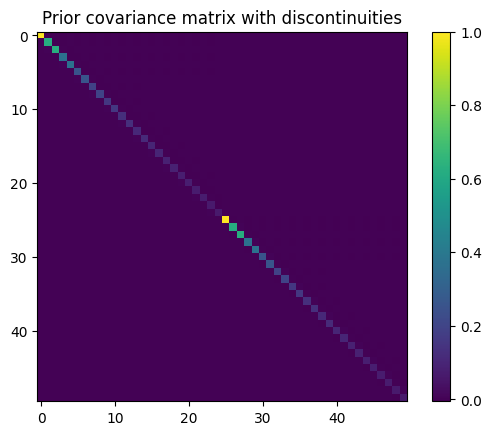

In [65]:
print(np.max(np.abs(C_mat - C_mat.T)))  # Check symmetry

print(np.allclose(C_mat, C_mat.T, rtol=1e-5))  # Check symmetry

C_mat_sym = (C_mat + C_mat.T)/2

try:
    cholesky(C_mat_sym, lower=False)   # or np.linalg.cholesky(A)
    print("PD (Cholesky succeeded)")
except LinAlgError:
    print("Not PD (Cholesky failed)")

plt.imshow(C_mat, cmap='viridis')
plt.colorbar()
plt.title("Prior covariance matrix with discontinuities")
plt.show()

In [66]:
C_mat_0 = covariances[0].matrix(dense=True, parallel=True, n_jobs=16)

In [69]:
print(covariances[0].domain.function_domain)
print(covariances[1].domain.function_domain)

[0.0, 0.5)
(0.5, 1.0]


0.009952128219701742
False
PD (Cholesky succeeded)


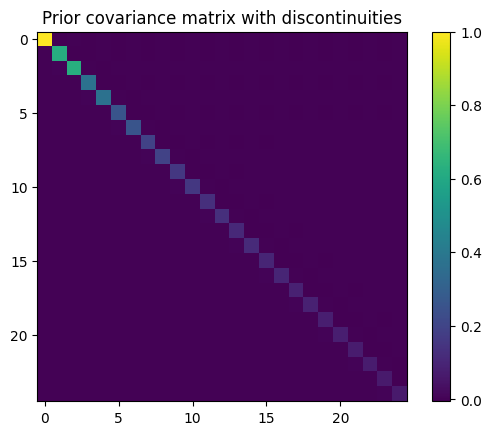

In [67]:
print(np.max(np.abs(C_mat_0 - C_mat_0.T)))  # Check symmetry

print(np.allclose(C_mat_0, C_mat_0.T, rtol=1e-5))  # Check symmetry

C_mat_0_sym = (C_mat_0 + C_mat_0.T)/2

try:
    cholesky(C_mat_0_sym, lower=False)   # or np.linalg.cholesky(A)
    print("PD (Cholesky succeeded)")
except LinAlgError:
    print("Not PD (Cholesky failed)")

plt.imshow(C_mat_0, cmap='viridis')
plt.colorbar()
plt.title("Prior covariance matrix with discontinuities")
plt.show()